# Section-1 Importing libraries and loading the datasets

In [390]:
#Importing the library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import warnings
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [373]:
#Unzipping the dataset
!unzip p2.zip

Archive:  p2.zip
replace boxes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: boxes.csv               
  inflating: problem 2.csv           
  inflating: purchase.csv            
  inflating: sample submission 2.csv  


In [374]:
#Loading the dataset
purchases = pd.read_csv('purchase.csv')
boxes = pd.read_csv('boxes.csv')
test = pd.read_csv('problem 2.csv')

# Section-2 Data Preprocessing: Summary Stats, Formatting, Cleaning

Preprocessing the dataset is necessary as garbage in is garbage out. If we analyze on data that without cleaning and formatting it then our results will be just as bad. Furthermore, we must also explore the dataset and get some key insights before delving into the analysis.

## Dataset Overview

In [4]:
purchases.shape

(2455864, 4)

The purchase dataset has 2455864 rows and 4 columns.

In [376]:
boxes.shape

(290, 6)

The boxes dataset has 290 rows and 6 columns.

We now have a look at the first five rows of both of the datasets.

In [5]:
purchases.head()

,PURCHASE_DATE,MAGIC_KEY,BOX_ID,BOX_COUNT
0,1/2/2019,2CED678A247,12.0,1.0
1,1/2/2019,2BF58D91BA1,12.0,1.0
2,1/2/2019,2C15B86534E,99.0,1.0
3,1/2/2019,2C32D9A859A,6.0,1.0
4,1/2/2019,2C7A55404D1,4.0,1.0


In [377]:
boxes.head()

,BOX_ID,QUALITY,DELIVERY_OPTION,MILK,MEAT,UNIT_PRICE
0,1,Premium,Home Delivery - CoD,0.0,2.7,9.96
1,2,Premium,Home Delivery - CoD,0.0,2.3,11.96
2,3,Premium,Home Delivery - CoD,0.0,2.4,11.96
3,4,Premium,Home Delivery - CoD,0.0,2.5,11.96
4,5,Premium,Home Delivery - CoD,0.0,2.6,11.96


In [378]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2455817 entries, 0 to 2455863
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   PURCHASE_DATE  object 
 1   MAGIC_KEY      object 
 2   BOX_ID         float64
 3   BOX_COUNT      float64
dtypes: float64(2), object(2)
memory usage: 93.7+ MB


In [379]:
boxes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BOX_ID           290 non-null    int64  
 1   QUALITY          290 non-null    object 
 2   DELIVERY_OPTION  290 non-null    object 
 3   MILK             290 non-null    float64
 4   MEAT             290 non-null    float64
 5   UNIT_PRICE       290 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 13.7+ KB


## Checking and removing null values

In [7]:
purchases.isnull().sum()

PURCHASE_DATE     0
MAGIC_KEY         0
BOX_ID           47
BOX_COUNT        47
dtype: int64

Looks like we have a few null values. Since, we are trying to predict the BOX_ID, the null values can be discarded.

In [375]:
purchases = purchases.dropna()

## Finding and removing outliers from purchases

In [8]:
purchases.describe()

,BOX_ID,BOX_COUNT
count,2.455817e+06,2.455817e+06
mean,2.308802e+02,1.001121e+00
std,2.923330e+04,4.467255e-02
min,1.000000e+00,-1.000000e+00
25%,1.060000e+02,1.000000e+00
50%,1.430000e+02,1.000000e+00
75%,2.150000e+02,1.000000e+00
max,1.111111e+07,1.900000e+01


Clearly shows a few outliers. Better to remove them.

The maxium box ID is 1111111 which is clearly an outliar while the box count 19 is also too high and needs to be removed. For this task, we can disregard removing the box count as our job is to predict the box ID only.

In [10]:
purchases['PURCHASE_DATE'].describe(), purchases['MAGIC_KEY'].describe()

(count                          2455864
 mean     2018-12-20 16:14:26.662974720
 min                2018-10-01 00:00:00
 25%                2018-11-11 00:00:00
 50%                2018-12-24 00:00:00
 75%                2019-01-30 00:00:00
 max                2019-02-28 00:00:00
 Name: PURCHASE_DATE, dtype: object,
 count         2455864
 unique        1274108
 top       2CC2011C2DF
 freq               40
 Name: MAGIC_KEY, dtype: object)

In [11]:
purchases['BOX_COUNT'].describe()

count    2.455817e+06
mean     1.001121e+00
std      4.467255e-02
min     -1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.900000e+01
Name: BOX_COUNT, dtype: float64

## Finding and removing outliers from boxes

In [12]:
boxes.shape #Max box_ID is clearly 290

(290, 6)

In [13]:
boxes.head()

,BOX_ID,QUALITY,DELIVERY_OPTION,MILK,MEAT,UNIT_PRICE
0,1,Premium,Home Delivery - CoD,0.0,2.7,9.96
1,2,Premium,Home Delivery - CoD,0.0,2.3,11.96
2,3,Premium,Home Delivery - CoD,0.0,2.4,11.96
3,4,Premium,Home Delivery - CoD,0.0,2.5,11.96
4,5,Premium,Home Delivery - CoD,0.0,2.6,11.96


Let's try to look for weird box IDs.

In [14]:
max(boxes['BOX_ID'])

290

In [15]:
purchases.loc[purchases['BOX_ID'] > 290, 'BOX_ID'] = None
purchases.loc[purchases['BOX_COUNT']<0, 'BOX_COUNT'] = None

## Formatting the data

Changing the date time format of our dataset.

In [9]:
purchases['PURCHASE_DATE'] = pd.to_datetime(purchases['PURCHASE_DATE'], format='%d/%m/%Y')
purchases

,PURCHASE_DATE,MAGIC_KEY,BOX_ID,BOX_COUNT
0,2019-02-01,2CED678A247,12.0,1.0
1,2019-02-01,2BF58D91BA1,12.0,1.0
2,2019-02-01,2C15B86534E,99.0,1.0
3,2019-02-01,2C32D9A859A,6.0,1.0
4,2019-02-01,2C7A55404D1,4.0,1.0
...,...,...,...,...
2455859,2018-10-28,2BD992B5538,12.0,1.0
2455860,2018-10-28,2C97CD72233,17.0,1.0
2455861,2018-10-28,2C91C61D372,40.0,1.0
2455862,2018-10-28,2CD70CFC4E3,51.0,1.0


# Section-3 Analysing and Visualizing

## Merging the data

Not all the data is required for analysis. Our concern is the MAGIC_KEYs from the problem2.csv only.

In [413]:
data = pd.merge(test, purchases, on = 'MAGIC_KEY', how = 'left')
data['PURCHASE_DATE'] = pd.to_datetime(data['PURCHASE_DATE'], format='%d/%m/%Y')
data.head()

,MAGIC_KEY,PURCHASE_DATE,BOX_ID,BOX_COUNT
0,2C0B5F97180,2019-02-03,141.0,1.0
1,2C0B5F97180,2019-01-04,137.0,1.0
2,2C0B5F97180,2018-11-09,137.0,1.0
3,2C0B5F97180,2018-11-02,89.0,1.0
4,2C0B5F97180,2018-10-10,137.0,1.0


## Which boxes are more frequent?

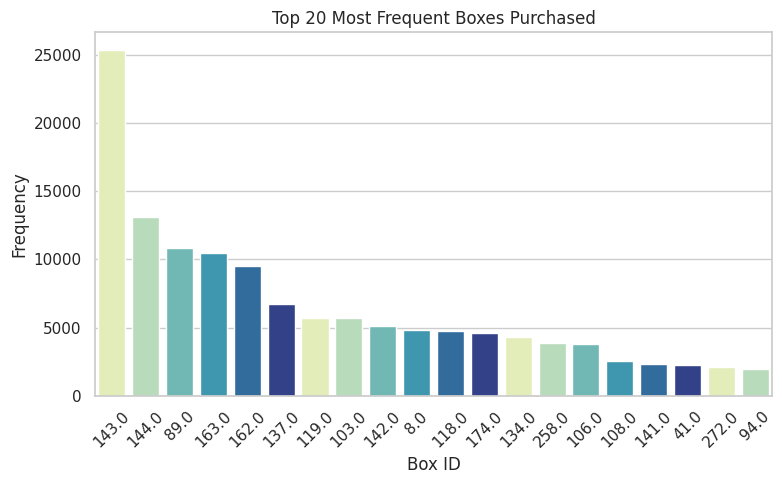

In [403]:
# Get the top 10 most frequent boxes
top_boxes = data['BOX_ID'].value_counts().nlargest(20)

# Set seaborn style and color palette
sns.set(style='whitegrid')
palette = sns.color_palette('YlGnBu')

# Plot the bar chart using seaborn
plt.figure(figsize=(8, 5))
sns.barplot(x=top_boxes.index, y=top_boxes.values, palette=palette, order=top_boxes.index)
plt.title('Top 20 Most Frequent Boxes Purchased')
plt.xlabel('Box ID')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

The top boxes are responsible for most of the purchases. We see ID 143 and 144 taking the top 2 spots with a very high frequency. Let's have a look at the frequencies of the BOX_IDs to have a better understanding.

In [404]:
print(data['BOX_ID'].value_counts())

BOX_ID
143.0    25391
144.0    13129
89.0     10807
163.0    10488
162.0     9514
         ...  
179.0        1
280.0        1
223.0        1
277.0        1
43.0         1
Name: count, Length: 199, dtype: int64


### What % of the total purchases have the top boxes?

In [406]:
data['BOX_ID'].value_counts().nlargest(50).sum()/data['BOX_ID'].value_counts().sum()

0.9414246048697138

The top 50 boxes are purchased in more than 94% of the transactions.

### What are the frequent box counts?

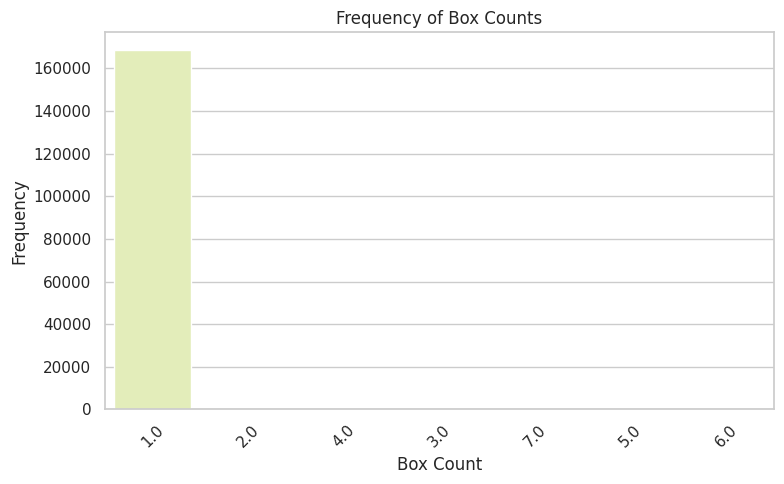

In [407]:
top_boxes = data['BOX_COUNT'].value_counts()

# Set seaborn style and color palette
sns.set(style='whitegrid')
palette = sns.color_palette('YlGnBu')

# Plot the bar chart using seaborn
plt.figure(figsize=(8, 5))
sns.barplot(x=top_boxes.index, y=top_boxes.values, palette=palette, order=top_boxes.index)
plt.title('Frequency of Box Counts')
plt.xlabel('Box Count')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [408]:
print(data['BOX_COUNT'].value_counts())

BOX_COUNT
1.0    168433
2.0       112
4.0         2
3.0         2
7.0         1
5.0         1
6.0         1
Name: count, dtype: int64


Most of the buyers purchased a single box.

### What % of people made multiple purchases? Did they purchase the same box or different boxes?

The BC counts the number of boxes purchased by a customer while the BV counts the different types of boxes purchased.

In [409]:
data['BC'] = data.groupby('MAGIC_KEY')['BOX_ID'].transform('count')
data['BV'] = data.groupby('MAGIC_KEY')['BOX_ID'].transform('nunique')

In [410]:
data.head()

,MAGIC_KEY,PURCHASE_DATE,BOX_ID,BOX_COUNT,BC,BV
0,2C0B5F97180,3/2/2019,141.0,1.0,5,3
1,2C0B5F97180,4/1/2019,137.0,1.0,5,3
2,2C0B5F97180,9/11/2018,137.0,1.0,5,3
3,2C0B5F97180,2/11/2018,89.0,1.0,5,3
4,2C0B5F97180,10/10/2018,137.0,1.0,5,3


# Section-4 Transforming the dataset

## Filtering older samples

Customers are inclined towards recent purchases i.e. they are more likely to purchase the box that they have recently purchased. Hence, we can disregard older data and will only be concerned with the last 2 months of data i.e. Jan and Feb.

In [414]:
filtered_data = data[(data['PURCHASE_DATE'].dt.month == 1) | (data['PURCHASE_DATE'].dt.month == 2)]
filtered_data

,MAGIC_KEY,PURCHASE_DATE,BOX_ID,BOX_COUNT
0,2C0B5F97180,2019-02-03,141.0,1.0
1,2C0B5F97180,2019-01-04,137.0,1.0
5,2C2F659EF00,2019-02-07,144.0,1.0
6,2C2F659EF00,2019-01-09,144.0,1.0
10,29D629EDF20,2019-02-07,230.0,1.0
...,...,...,...,...
168540,2C49CA2A632,2019-01-31,108.0,1.0
168543,2C49D52753F,2019-02-13,42.0,1.0
168544,2C49D52753F,2019-01-14,44.0,1.0
168549,2C49DF0ADB4,2019-02-01,134.0,1.0


## Dropping redundant columns

The number of boxes purchased isn't needed and can be dropped.

In [416]:
filtered_data = filtered_data.drop(columns=['BOX_COUNT'])

## Quantize Boxes

As seen previously, some of the classes are responsible for most of the purchases. Hence, we take the top 50 purchases to make the prediction easier for our predictive model. We also quantize the boxes from 0 to 49, and put the others in 50.

In [422]:
dataQ = filtered_data.copy()
top_50_box_ids = dataQ['BOX_ID'].value_counts().nlargest(50).index

# Create a mapping dictionary for the top 50 BOX_IDs
box_id_mapping = {box_id: idx for idx, box_id in enumerate(top_50_box_ids)}

# Map the top 50 BOX_IDs to integers from 0 to 49, and map the rest to 50
dataQ['BOX_ID'] = dataQ['BOX_ID'].map(box_id_mapping).fillna(50)

### The mapping dictionary of our BOX_IDs

In [423]:
for box_id, idx in box_id_mapping.items():
    print(f"{box_id}: {idx}")

144.0: 0
162.0: 1
119.0: 2
89.0: 3
143.0: 4
118.0: 5
174.0: 6
106.0: 7
141.0: 8
103.0: 9
272.0: 10
142.0: 11
8.0: 12
108.0: 13
258.0: 14
94.0: 15
90.0: 16
42.0: 17
110.0: 18
44.0: 19
9.0: 20
77.0: 21
27.0: 22
31.0: 23
255.0: 24
134.0: 25
131.0: 26
137.0: 27
126.0: 28
238.0: 29
133.0: 30
41.0: 31
230.0: 32
231.0: 33
166.0: 34
237.0: 35
204.0: 36
155.0: 37
138.0: 38
104.0: 39
203.0: 40
96.0: 41
76.0: 42
246.0: 43
51.0: 44
217.0: 45
80.0: 46
45.0: 47
245.0: 48
270.0: 49


# Section-5 Predicting boxes with Data Variety more than 2

We strongly assume that the users who purchased a single variety will purchase that product in the next purchases. Hence, our concern is the users who purchased different kinds of products.

We include the box count and box variety columns again in DQ.

In [424]:
dataQ['BC'] = dataQ.groupby('MAGIC_KEY')['BOX_ID'].transform('count')
dataQ['BV'] = dataQ.groupby('MAGIC_KEY')['BOX_ID'].transform('nunique')
dataQ

,MAGIC_KEY,PURCHASE_DATE,BOX_ID,BC,BV
0,2C0B5F97180,2019-02-03,8.0,2,2
1,2C0B5F97180,2019-01-04,27.0,2,2
5,2C2F659EF00,2019-02-07,0.0,2,1
6,2C2F659EF00,2019-01-09,0.0,2,1
10,29D629EDF20,2019-02-07,32.0,4,3
...,...,...,...,...,...
168540,2C49CA2A632,2019-01-31,13.0,1,1
168543,2C49D52753F,2019-02-13,17.0,2,2
168544,2C49D52753F,2019-01-14,19.0,2,2
168549,2C49DF0ADB4,2019-02-01,25.0,2,2


dataE1 is the first extraction where we are taking users who purchased at least 2 kinds of products.

In [425]:
dataE1 = dataQ[dataQ['BV']>=2]
dataE1.drop(columns=['BC','BV'], inplace=True)

## Feature Engineering

### Top Box-1,2 and their counts

We create four new features that will track the most purchased and second most purchased box ID by a particular customer and their respective counts. This feature will capture the temporal information that is usually lost when aggregating the data.

In [150]:
# Group transactions by CUSTOMER_ID
grouped = dataE1.groupby('MAGIC_KEY')

# Define a function to get the top 2 boxes for each customer
def top_2_boxes(group):
    top_2 = list(group['BOX_ID'].value_counts().nlargest(2).index)
    top_2.extend(group['BOX_ID'].value_counts().nlargest(2).tolist())
    return pd.Series(top_2, index=['Top_Box1', 'Top_Box2','BC1','BC2'])

# Apply the function to each group and reset index to merge with the original DataFrame
top_boxes_df = grouped.apply(top_2_boxes).reset_index()

# Merge the top_boxes_df with the original DataFrame on 'CUSTOMER_ID'
result_df = pd.merge(dataE1, top_boxes_df, on='MAGIC_KEY')
result_df

,MAGIC_KEY,PURCHASE_DATE,BOX_ID,Top_Box1,Top_Box2,BC1,BC2
0,2C0B5F97180,2019-02-03,8.0,27.0,8.0,3.0,1.0
1,2C0B5F97180,2019-01-04,27.0,27.0,8.0,3.0,1.0
2,2C0B5F97180,2018-11-09,27.0,27.0,8.0,3.0,1.0
3,2C0B5F97180,2018-11-02,3.0,27.0,8.0,3.0,1.0
4,2C0B5F97180,2018-10-10,27.0,27.0,8.0,3.0,1.0
...,...,...,...,...,...,...,...
150405,2C49D52753F,2018-11-04,50.0,31.0,50.0,2.0,2.0
150406,2C49D52753F,2018-10-10,50.0,31.0,50.0,2.0,2.0
150407,2C49DF0ADB4,2019-02-01,25.0,25.0,30.0,2.0,1.0
150408,2C49DF0ADB4,2019-01-01,30.0,25.0,30.0,2.0,1.0


### Latest purchase date and ID.

We track the latest purchase BOX_ID and the date which will be used to calculate the time since last purchase.

In [426]:
def latest_purchase(group):
    latest_date = group['PURCHASE_DATE'].max()
    latest_box = group.loc[group['PURCHASE_DATE'] == latest_date, 'BOX_ID'].iloc[0]
    return pd.Series({'LATEST_PURCHASE_DATE': latest_date, 'LATEST_BOX_ID': latest_box})

# Group by 'MAGIC_KEY' and apply the custom aggregation function
aggregated_df = result_df.groupby('MAGIC_KEY').apply(latest_purchase)

# Reset index to flatten the DataFrame
aggregated_df.reset_index(inplace=True)
aggregated_df

,MAGIC_KEY,LATEST_PURCHASE_DATE,LATEST_BOX_ID
0,297D1B85F05,2019-02-01,10.0
1,297D1E96722,2019-02-11,10.0
2,297D1EE2EFE,2019-02-23,32.0
3,297D2075EEB,2019-02-08,10.0
4,297D2170E3C,2019-02-20,14.0
...,...,...,...
37014,2C49E27C64E,2019-02-01,1.0
37015,2C49E2886F3,2019-01-31,1.0
37016,2C49E79B9AC,2019-02-01,27.0
37017,2C49F518CE1,2019-01-31,25.0


We now merge the features into a single dataset.

In [154]:
result_df2= result_df.merge(aggregated_df, on='MAGIC_KEY', how = 'inner')

In [427]:
result_df2

,MAGIC_KEY,PURCHASE_DATE,BOX_ID,Top_Box1,Top_Box2,BC1,BC2,LATEST_PURCHASE_DATE,LATEST_BOX_ID,MONTH_DAY
0,2C0B5F97180,2019-02-03,8.0,27.0,8.0,3.0,1.0,2019-02-03,8.0,02-03
1,2C0B5F97180,2019-01-04,27.0,27.0,8.0,3.0,1.0,2019-02-03,8.0,01-04
2,2C0B5F97180,2018-11-09,27.0,27.0,8.0,3.0,1.0,2019-02-03,8.0,11-09
3,2C0B5F97180,2018-11-02,3.0,27.0,8.0,3.0,1.0,2019-02-03,8.0,11-02
4,2C0B5F97180,2018-10-10,27.0,27.0,8.0,3.0,1.0,2019-02-03,8.0,10-10
...,...,...,...,...,...,...,...,...,...,...
150405,2C49D52753F,2018-11-04,50.0,31.0,50.0,2.0,2.0,2019-02-13,17.0,11-04
150406,2C49D52753F,2018-10-10,50.0,31.0,50.0,2.0,2.0,2019-02-13,17.0,10-10
150407,2C49DF0ADB4,2019-02-01,25.0,25.0,30.0,2.0,1.0,2019-02-01,25.0,02-01
150408,2C49DF0ADB4,2019-01-01,30.0,25.0,30.0,2.0,1.0,2019-02-01,25.0,01-01


We take the purchases from last 2 months in the train set as discussed previously.

In [156]:
train_set = result_df2[result_df['PURCHASE_DATE'].dt.month <3]

### Last Purchase Time

We calculate the last purchase time by taking the difference with the purchase date of the last product and 01/03/2019.

In [158]:
reference_date = pd.to_datetime('01/03/19', format='%d/%m/%y')
train_set['LATEST_PURCHASE_DATE'] = reference_date - train_set['LATEST_PURCHASE_DATE']
train_set['PURCHASE_DATE'] = reference_date - train_set['PURCHASE_DATE']
train_set

<ipython-input-158-5bd9e883ffd8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['LATEST_PURCHASE_DATE'] = reference_date - train_set['LATEST_PURCHASE_DATE']
<ipython-input-158-5bd9e883ffd8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['PURCHASE_DATE'] = reference_date - train_set['PURCHASE_DATE']


,MAGIC_KEY,PURCHASE_DATE,BOX_ID,Top_Box1,Top_Box2,BC1,BC2,LATEST_PURCHASE_DATE,LATEST_BOX_ID
0,2C0B5F97180,26 days,8.0,27.0,8.0,3.0,1.0,26 days,8.0
1,2C0B5F97180,56 days,27.0,27.0,8.0,3.0,1.0,26 days,8.0
5,2C2F659EF00,22 days,0.0,4.0,0.0,3.0,2.0,22 days,0.0
6,2C2F659EF00,51 days,0.0,4.0,0.0,3.0,2.0,22 days,0.0
10,29D629EDF20,22 days,32.0,29.0,35.0,3.0,2.0,10 days,35.0
...,...,...,...,...,...,...,...,...,...
150398,2C49CA2A632,29 days,13.0,13.0,39.0,2.0,1.0,29 days,13.0
150401,2C49D52753F,16 days,17.0,31.0,50.0,2.0,2.0,16 days,17.0
150402,2C49D52753F,46 days,19.0,31.0,50.0,2.0,2.0,16 days,17.0
150407,2C49DF0ADB4,28 days,25.0,25.0,30.0,2.0,1.0,28 days,25.0


Changing data types

In [160]:
train_set['PURCHASE_DATE'] = train_set['PURCHASE_DATE'].dt.days.astype(int)

<ipython-input-160-8a0e8c7f9936>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['PURCHASE_DATE'] = train_set['PURCHASE_DATE'].dt.days.astype(int)


In [162]:
train_set['LATEST_PURCHASE_DATE'] = train_set['LATEST_PURCHASE_DATE'].dt.days.astype(int)

<ipython-input-162-0cd9282c0e23>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['LATEST_PURCHASE_DATE'] = train_set['LATEST_PURCHASE_DATE'].dt.days.astype(int)


# Section-6 Experiments

## Dividing train splits

Divide the training input and output data. We willing opted to not consider test accuracy as the trends change and predicting the last 15 days of February based on the previous days may not be equivalent to predicting on first 15 days of March.

In [250]:
trainX = np.array(train_set[['PURCHASE_DATE','LATEST_BOX_ID','LATEST_PURCHASE_DATE','Top_Box1','Top_Box2','BC1','BC2']])
trainy = np.array(train_set[['BOX_ID']]).ravel()

## Picking classifiers

### XGBoost

In [360]:
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=51, random_state=42)
xgb_clf.fit(trainX, trainy)

# Make predictions on the test set
y_pred = xgb_clf.predict(trainX)

# Calculate accuracy
accuracy = accuracy_score(trainy, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9859320563893748


### Random Forest Classifier

In [303]:
model = RandomForestClassifier(max_depth= None, max_features= 'auto', min_samples_leaf= 1, n_estimators= 300, random_state=42)
model.fit(trainX, trainy)
train_predictions = model.predict(trainX)
train_accuracy = accuracy_score(trainy, train_predictions)
train_accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


0.9936642803592691

Random forest performs best and will be hence, tuned. For this particular instance, the hyperparameters were changed after finding the best set of hyperparameters from the next subsection.

### Insight: Although, the training accuracy is very high, the submission accuracy is relatively low due to the decision tree overfitting the training dataset.

## Hyperparameter Tuning: Using Grid Search

We found the best model, now we need to find the best set of parameters. Hence, we perform grid search which is an exhaustive search on the parameter space of the random forest classifier.

In [300]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['auto', 'sqrt']
}

# Initialize Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with Random Forest classifier and parameter grid
grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='accuracy')

# Perform grid search to find the best parameters
grid_search.fit(trainX, trainy)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best Parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 300}


## Predicting on test set

In [361]:
tM = train_set[['MAGIC_KEY','LATEST_BOX_ID','LATEST_PURCHASE_DATE','Top_Box1','Top_Box2','BC1','BC2']].drop_duplicates()
tMk = tM.copy()
tMk['MAGIC_KEY'] = 0
tMk.rename(columns={'MAGIC_KEY': 'PURCHASE_DATE'}, inplace=True)
tMX = tMk[['PURCHASE_DATE','LATEST_BOX_ID','LATEST_PURCHASE_DATE','Top_Box1','Top_Box2','BC1','BC2']]
tMk['MAGIC_KEY'] = tM['MAGIC_KEY']
testPred = model.predict(tMX)

### Reverse Mapping of the previously mapped inputs

In [341]:
reverse_mapping = {idx: box_id for box_id, idx in box_id_mapping.items()}
reverse_mapping

{0: 144.0,
 1: 162.0,
 2: 119.0,
 3: 89.0,
 4: 143.0,
 5: 118.0,
 6: 174.0,
 7: 106.0,
 8: 141.0,
 9: 103.0,
 10: 272.0,
 11: 142.0,
 12: 8.0,
 13: 108.0,
 14: 258.0,
 15: 94.0,
 16: 90.0,
 17: 42.0,
 18: 110.0,
 19: 44.0,
 20: 9.0,
 21: 77.0,
 22: 27.0,
 23: 31.0,
 24: 255.0,
 25: 134.0,
 26: 131.0,
 27: 137.0,
 28: 126.0,
 29: 238.0,
 30: 133.0,
 31: 41.0,
 32: 230.0,
 33: 231.0,
 34: 166.0,
 35: 237.0,
 36: 204.0,
 37: 155.0,
 38: 138.0,
 39: 104.0,
 40: 203.0,
 41: 96.0,
 42: 76.0,
 43: 246.0,
 44: 51.0,
 45: 217.0,
 46: 80.0,
 47: 45.0,
 48: 245.0,
 49: 270.0}

50 was assigned to the rest of the values not belonging to the reduced set of classes. Hence, they will be set to null and will be replaced by their recent values.

In [342]:
testPred
testPred[testPred==50] = None

Mapping back the values.

In [344]:
box_ids = [reverse_mapping[idx] if idx in reverse_mapping else None for idx in testPred]
box_ids = np.array(box_ids)

In [346]:
tM['yPred'] = box_ids

In [348]:
predU = pd.merge(test,tM, on = 'MAGIC_KEY', how = 'left')
predU = predU[['MAGIC_KEY','yPred']]

### Recently purchased boxes

We find the most recently purchased and box and replace the null values with those values.

In [349]:
latest_purchase_dates = data.loc[data.groupby('MAGIC_KEY')['PURCHASE_DATE'].idxmax()]

In [353]:
predU['yPred'].fillna(latest_purchase_dates['BOX_ID'], inplace=True)

We finally create the prediction file for submission.

In [359]:
predU.rename(columns={'yPred': 'BOX_ID'}, inplace=True)
predU.to_csv("predU3.csv", index=False)